A notebook which contains an evaluation of the SalishSeaCast model within PugetSound for the year 2010. More specifically, it compares observed data on various nutrient concentrations collected from bottle data and compares it to model outputs. It also looks at temperature and salinity data collected from CTD data and compares model error to these environmental variables. This evaluation includes scatter plots and 2d histograms visualizing the similarity of observed and model data as well as tables of evaluation statistics.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=[2009,2010]
year=2010
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Year: 2010'''))

## Year: 2010

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

## Yearly model-data comparisons of nutrients, chlorophyll, temperature and salinity between 201905 runs and WADE observations

In [6]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{years[0]}.pkl'),'rb') as hh:
    data2009=pickle.load(hh)
with open(os.path.join(saveloc,f'data_WADE_{modelversion}_{years[1]}.pkl'),'rb') as hh:
    data2010=pickle.load(hh)
    
data=pd.concat((data2009,data2010),ignore_index=True)

In [7]:
datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion]   

In [8]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz=(data.Z<15)
DJF=data.loc[iz&(data.dtUTC>=dt.datetime(years[0],12,1))&(data.dtUTC<=dt.datetime(years[1],3,1)),:]
MAM=data.loc[iz&(data.dtUTC<=dt.datetime(years[1],5,1))&(data.dtUTC>dt.datetime(years[1],4,1)),:]
JJA=data.loc[iz&(data.dtUTC<=dt.datetime(years[1],9,1))&(data.dtUTC>dt.datetime(years[1],5,1)),:]
SON=data.loc[iz&(data.dtUTC>dt.datetime(years[1],9,1))&(data.dtUTC<=dt.datetime(years[1],12,31)),:]

In [9]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, DJF':DJF,
                      'z < 15 m, MAM':MAM,
                      'z < 15 m, JJA':JJA,
                      'z < 15 m, SON': SON,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, DJF', 'z < 15 m, MAM', 'z < 15 m, JJA', 'z < 15 m, SON', 'Hood Canal Basin', 'Main Basin', 'Admiralty Inlet', 'Strait of Georgia', 'Whidbey Basin', 'South Basin'])

## Map of observation locations in each basin

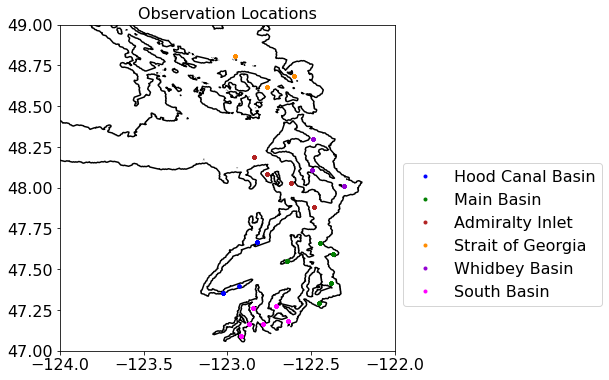

In [10]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data.Basin.unique()):
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Nitrate

### Table containing evaluation statistics for relevant subsets

In [36]:
# Defining variables needed for nitrate evaluations
obsvar='NO23'
modvar='mod_nitrate'

In [37]:
statsDict={year:dict()}
statsDict[year]['NO3']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['NO3'][isub]=dict()
    var=statsDict[year]['NO3'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NO3'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, DJF
z < 15 m, MAM
z < 15 m, JJA
z < 15 m, SON
Hood Canal Basin
Main Basin
Admiralty Inlet
Strait of Georgia
Whidbey Basin
South Basin


/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


### Model vs Observed comparisons by depth and region

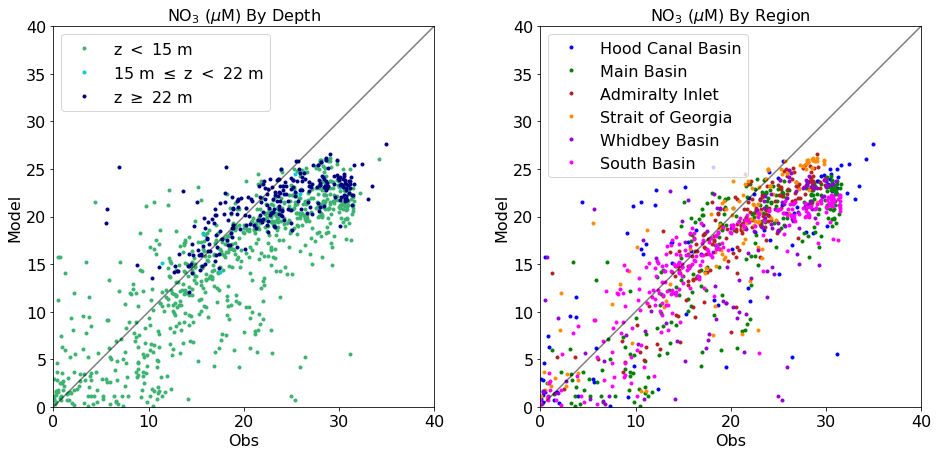

In [38]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,(0,40))
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,(0,40))
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

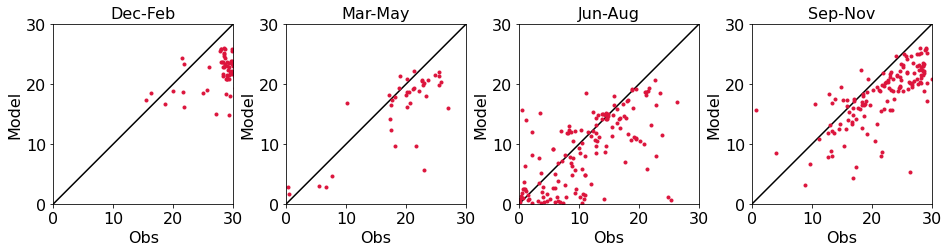

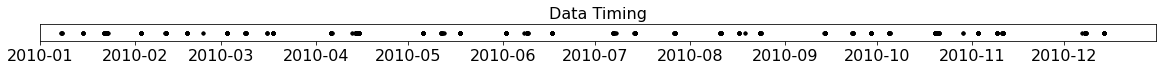

In [39]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,(0,30),season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

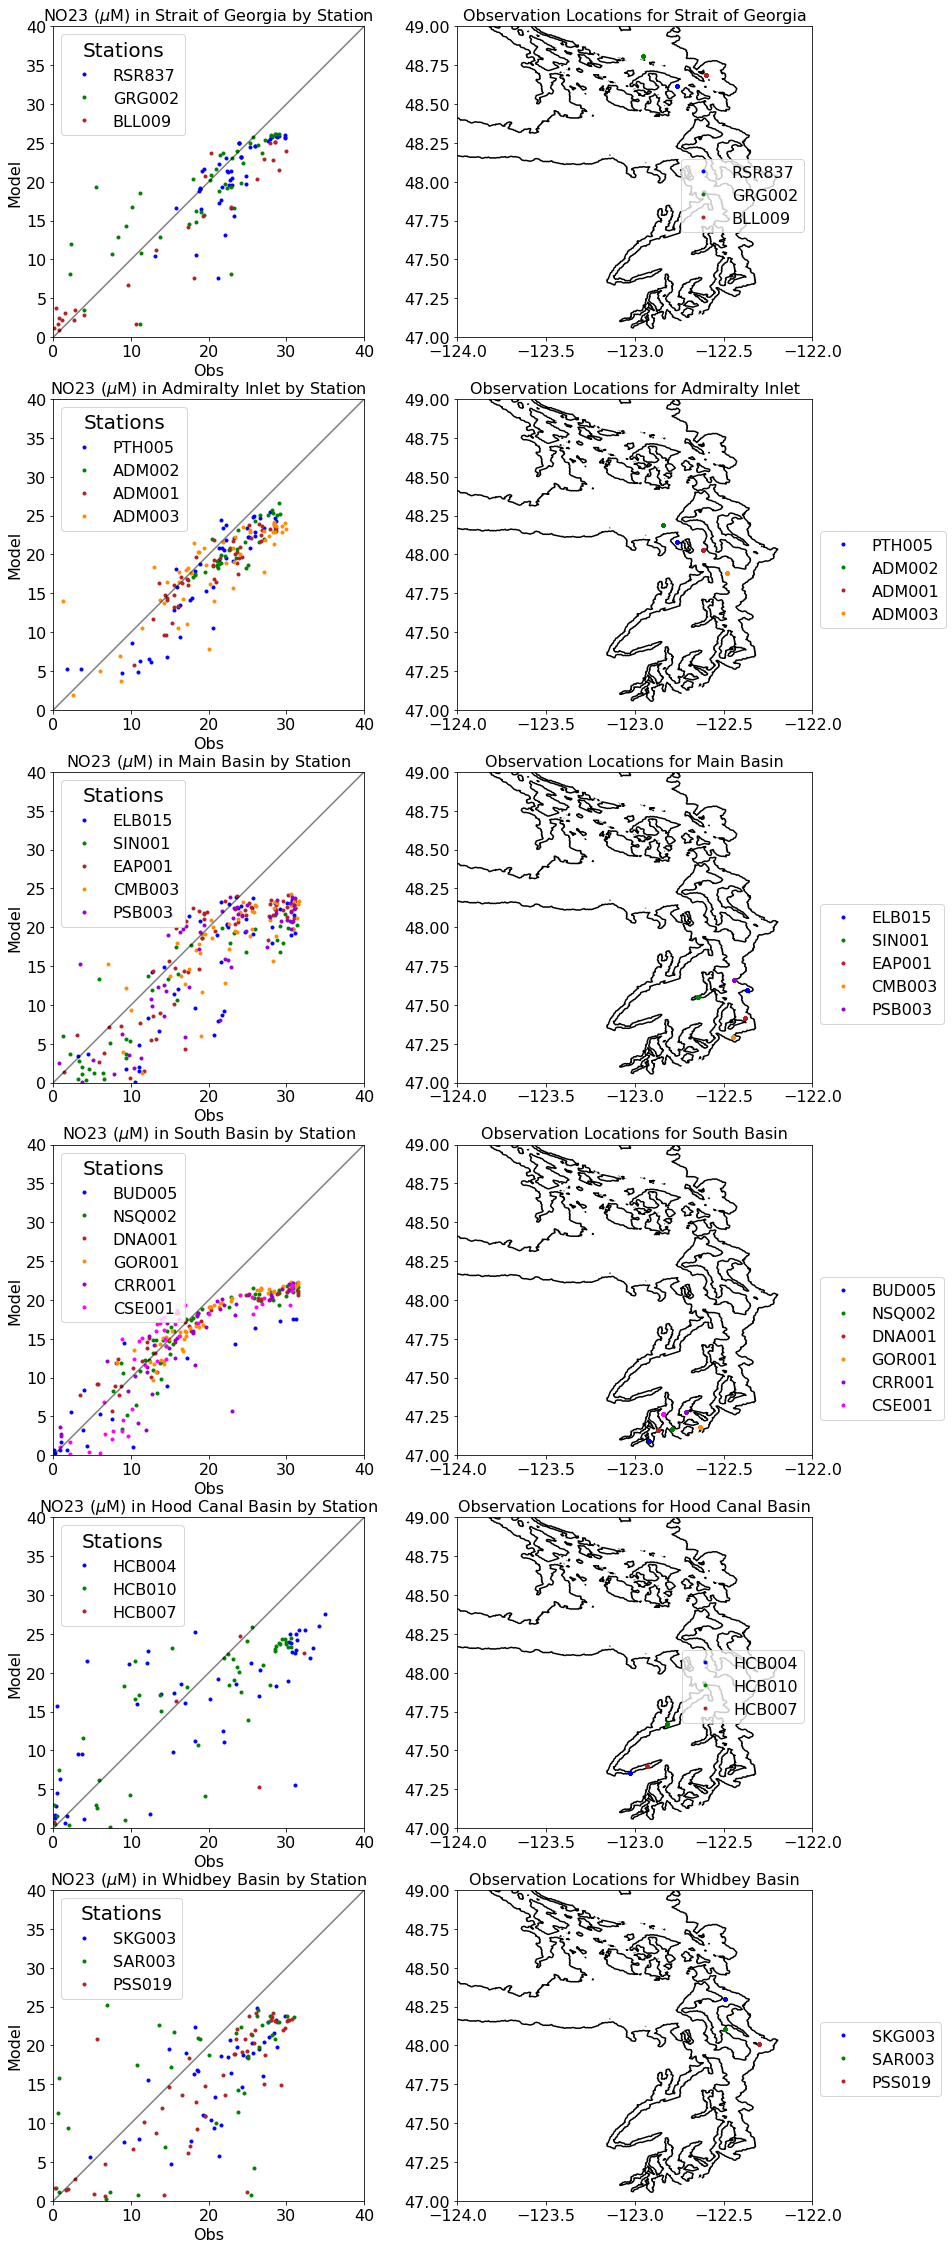

In [40]:
obsvar='NO23'
modvar='mod_nitrate'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(0,40)

ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

# Dissolved Silica

### Table containing evaluation statistics for relevant subsets

In [41]:
# Defining Variables needed for silica determination 
obsvar='Si'
modvar='mod_silicon'

In [42]:
statsDict[year]['dSi']=OrderedDict()
for isub in statsubs:
    statsDict[year]['dSi'][isub]=dict()
    var=statsDict[year]['dSi'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['dSi'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


### Model vs Observed comparisons by depth and region

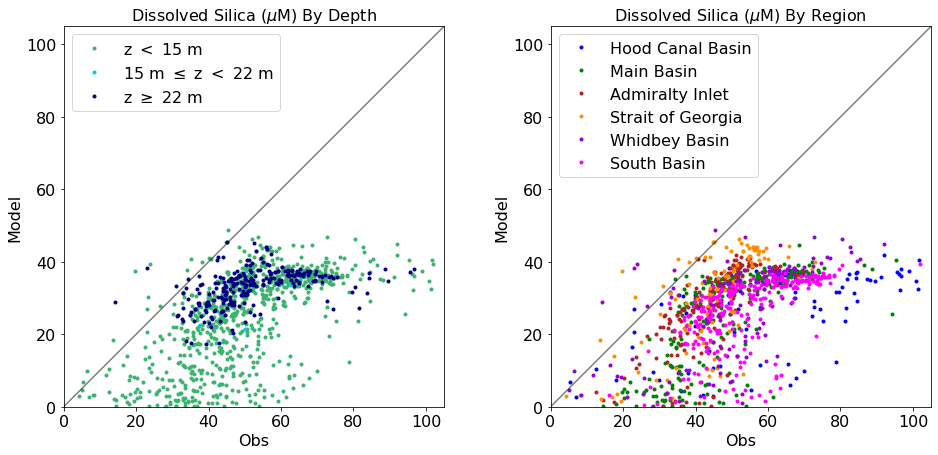

In [43]:
mv=(0,105)
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,mv)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,mv)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

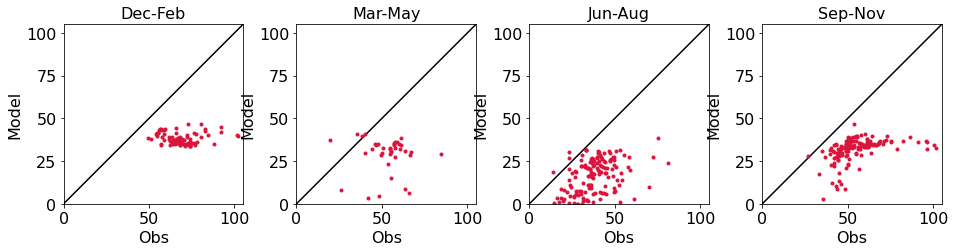

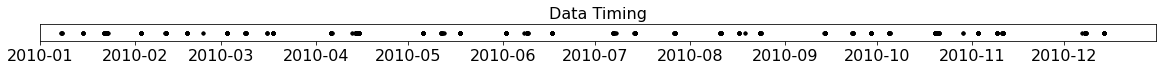

In [44]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,mv,season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

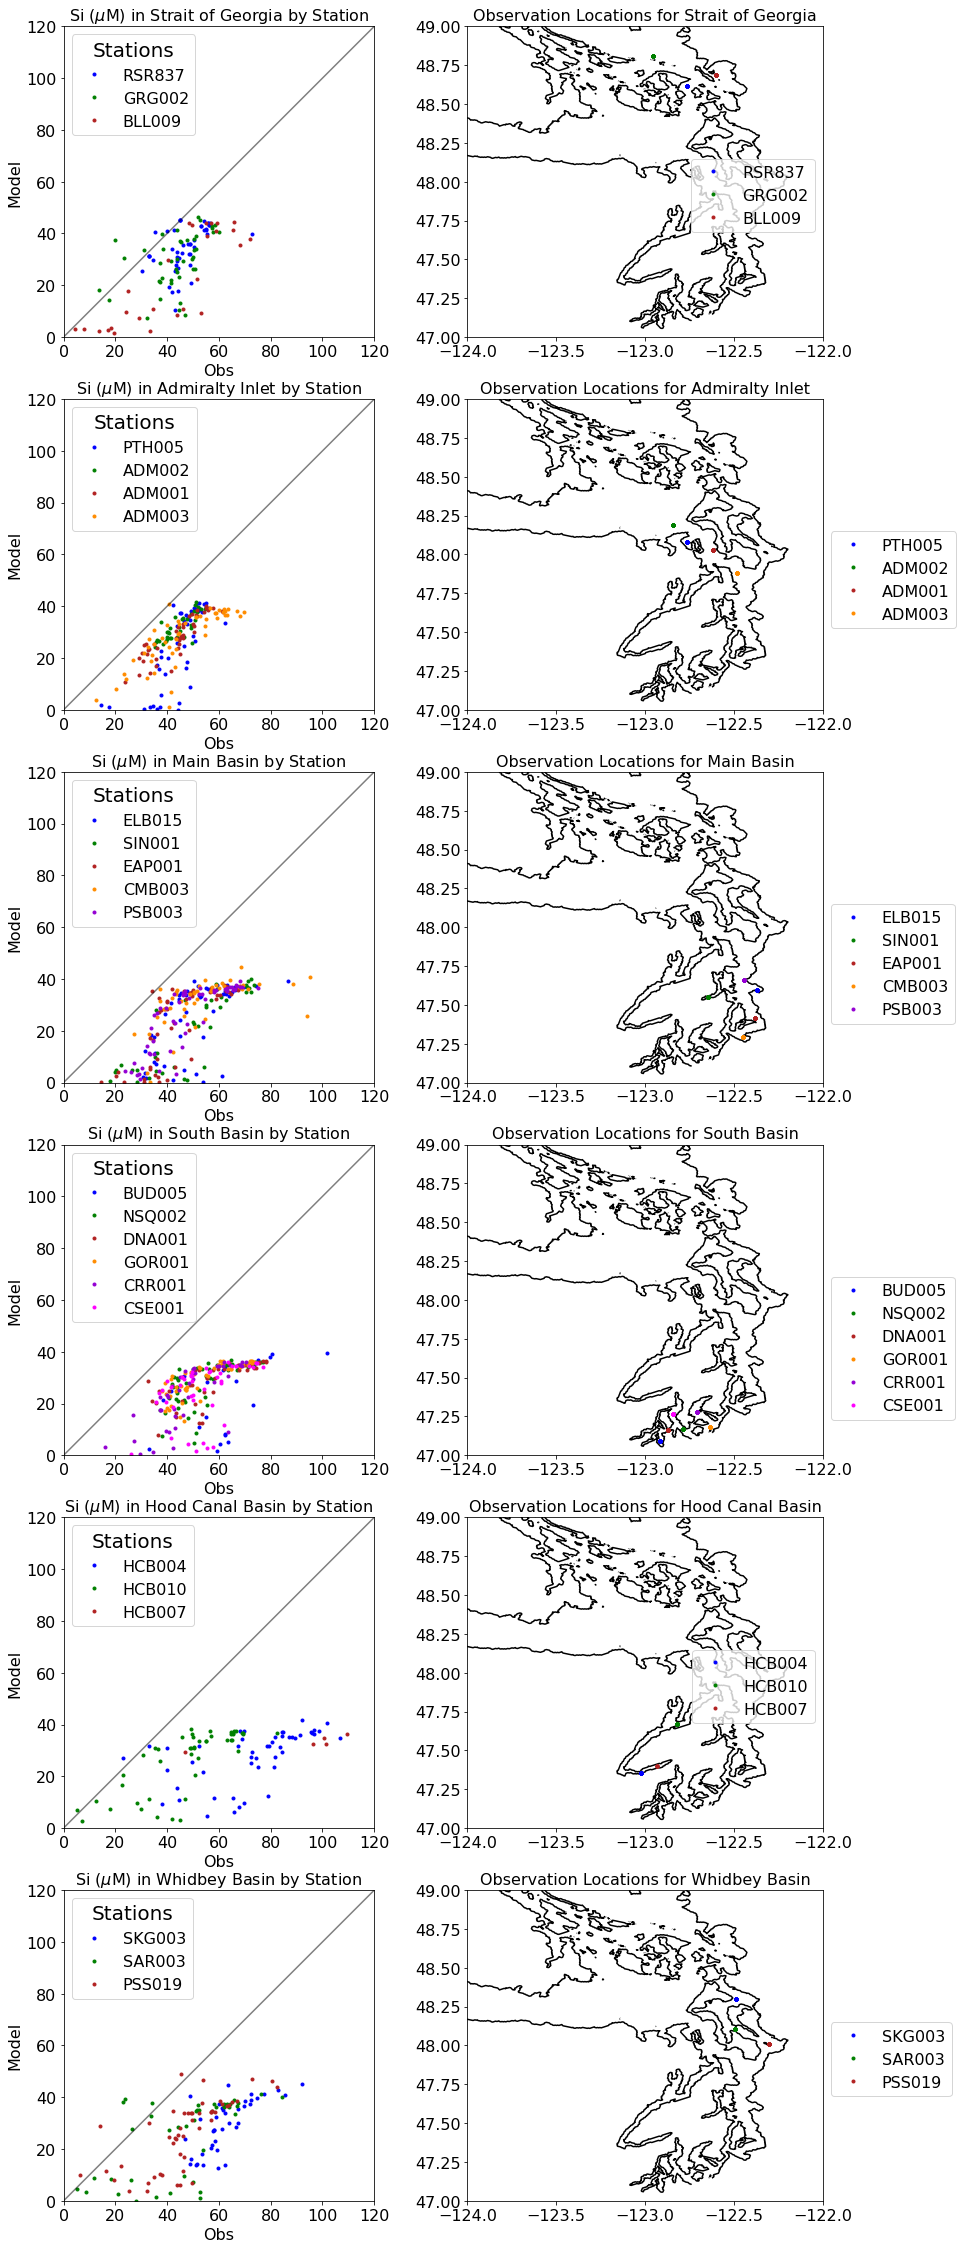

In [20]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(0,120)

ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

### Profiles of NO3 and Dissolved Silica

Text(0.5, 1.0, 'dSi')

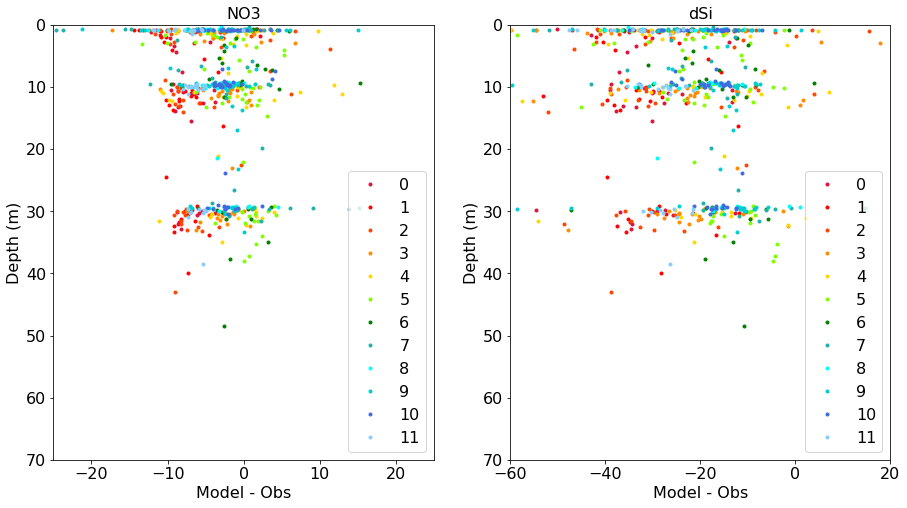

In [21]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)

fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

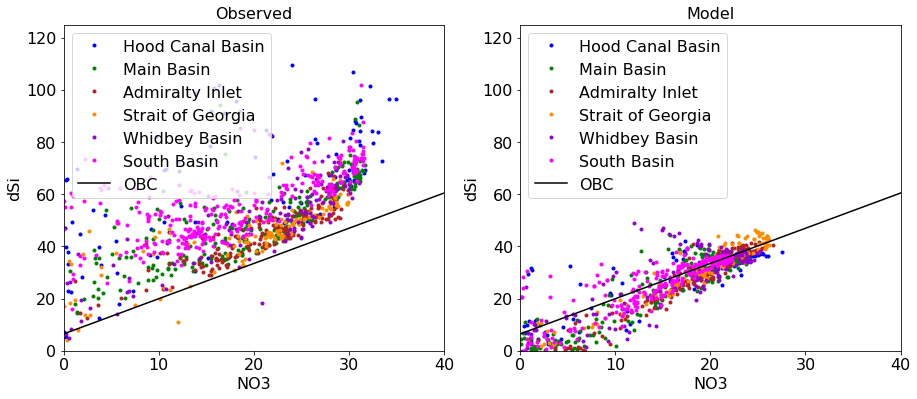

In [22]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,125)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',  
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,125)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# NH4

### Table containing evaluation statistics for relevant subsets

In [46]:
# Defining Variables for determining Ammonium
obsvar='Amm'
modvar='mod_ammonium'
seasons=[DJF,MAM,JJA,SON]

In [47]:
statsDict[year]['NH4']=OrderedDict()
for isub in statsubs:
    statsDict[year]['NH4'][isub]=dict()
    var=statsDict[year]['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict[year]['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/kflanaga/miniconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1136: RuntimeWarning: invalid value encountered in double_scalars
  return np.sqrt(np.sum((mod-obs)**2)/len(mod))
/ocean/kflanaga/MEOPAR/tools/SalishSeaTools/salishsea_tools/evaltools.py:1132: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0-np.sum((mod-obs)**2)/np.sum((np.abs(mod-np.mean(obs))+np.abs(obs-np.mean(obs)))**2)


### Model vs Observed comparisons by depth and region

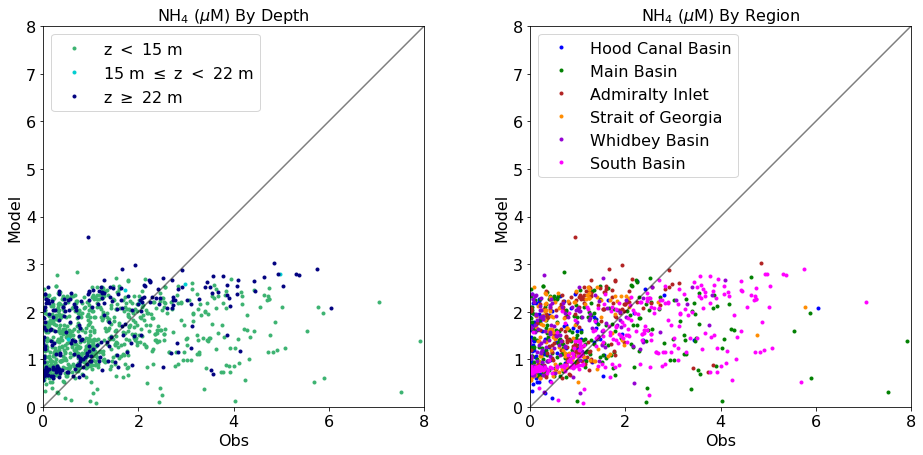

In [48]:
fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,(0,8))
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,(0,8))
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

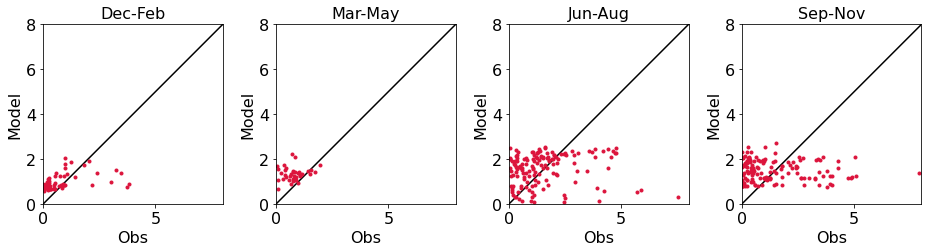

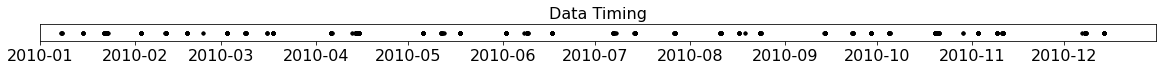

In [49]:
seasons=[DJF,MAM,JJA,SON]
season_titles=['Dec-Feb','Mar-May','Jun-Aug','Sep-Nov']

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,(0,8),season_titles)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('Data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

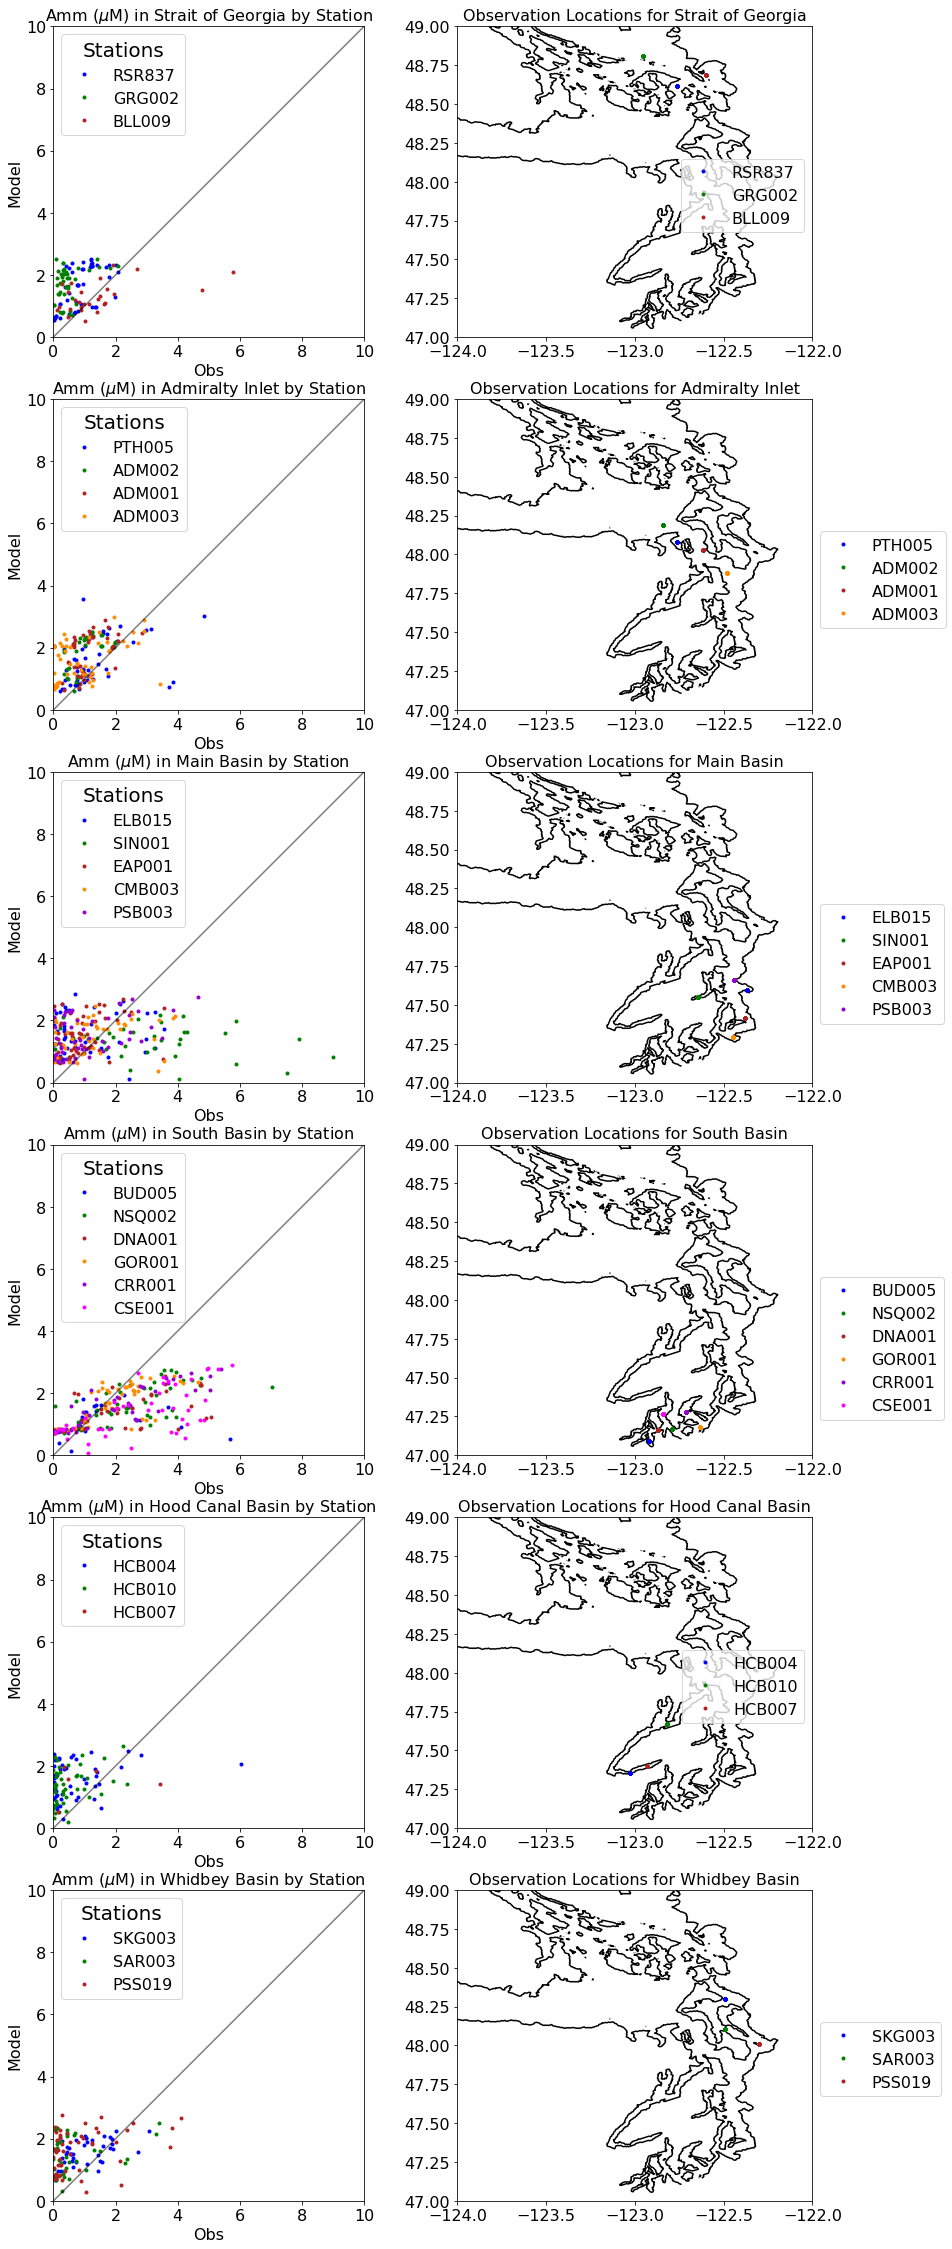

In [27]:
obsvar='Amm'
modvar='mod_ammonium'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(0,10)

ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

## Error vs temperature

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

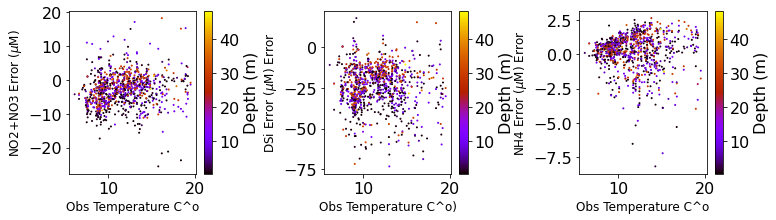

In [28]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['CT'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot') # what is a gnuplot and what are the other options for this?
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['CT'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Obs Temperature C^o)',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['CT'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Obs Temperature C^o',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

#Ask Susan and Elise about the specific ways they like to view the error plots. 

## Error vs salinity

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

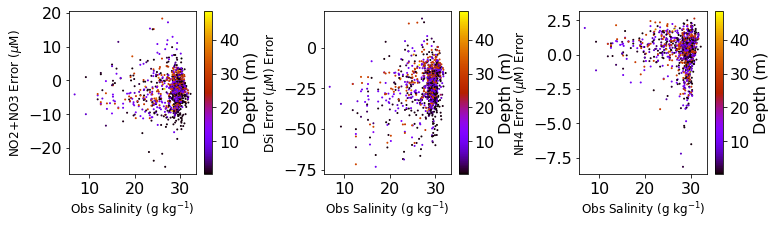

In [29]:
fig,ax=plt.subplots(1,3,figsize=(12,3))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['SA'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot') # what is a gnuplot and what are the other options for this?
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['SA'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['SA'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Obs Salinity (g kg$^{-1}$)',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

## Error vs salinity error

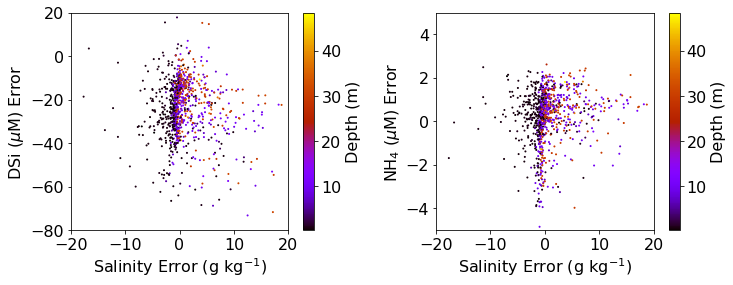

In [30]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[0].set_ylabel('DSi ($\mu$M) Error')
m,cb=ket.ErrErr(data,fig,ax[0],'SA','mod_vosaline','Si','mod_silicon',(-20,20),(-80,20))
ax[1].set_xlabel('Salinity Error (g kg$^{-1}$)')
ax[1].set_ylabel('NH$_4$ ($\mu$M) Error')
m,cb=ket.ErrErr(data,fig,ax[1],'SA','mod_vosaline','Amm','mod_ammonium',(-20,20),(-5,5))

## Error vs lat

Text(0, 0.5, 'NH4 Error ($\\mu$M) Error')

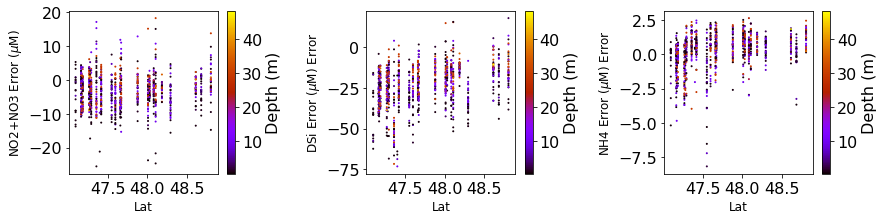

In [31]:
fig,ax=plt.subplots(1,3,figsize=(14,3))
fig.subplots_adjust(wspace=.6)
m=ax[0].scatter(data['Lat'],data['mod_nitrate']-data['NO23'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[0],label='Depth (m)')
ax[0].set_xlabel('Lat',fontsize=12)
ax[0].set_ylabel('NO2+NO3 Error ($\mu$M)',fontsize=12)

m=ax[1].scatter(data['Lat'],data['mod_silicon']-data['Si'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[1],label='Depth (m)')
ax[1].set_xlabel('Lat',fontsize=12)
ax[1].set_ylabel('DSi Error ($\mu$M) Error',fontsize=12)

m=ax[2].scatter(data['Lat'],data['mod_ammonium']-data['Amm'],c=data['Z'],s=1,cmap='gnuplot')
cb=fig.colorbar(m,ax=ax[2],label='Depth (m)')
ax[2].set_xlabel('Lat',fontsize=12)
ax[2].set_ylabel('NH4 Error ($\mu$M) Error',fontsize=12)

In [32]:
tbl,tdf=et.displayStats(statsDict[year],level='Variable',suborder=list(statsubs.keys()))
tbl

In [33]:
data.columns

Index(['Station', 'Desig', 'Descrip', 'Basin', 'Max_Depth', 'Lat', 'Lon',
       'Date', 'dtUTC', 'Z', 'PO4(uM)D', 'SiOH4(uM)D', 'NO3(uM)D', 'NO2(uM)D',
       'NH4(uM)D', 'DIN', 'Znom', 'NO23', 'Amm', 'Si', 'Year', 'YD', 'SA',
       'CT', 'j', 'i', 'mod_nitrate', 'mod_silicon', 'mod_ammonium',
       'mod_diatoms', 'mod_ciliates', 'mod_flagellates', 'mod_votemper',
       'mod_vosaline', 'k'],
      dtype='object')

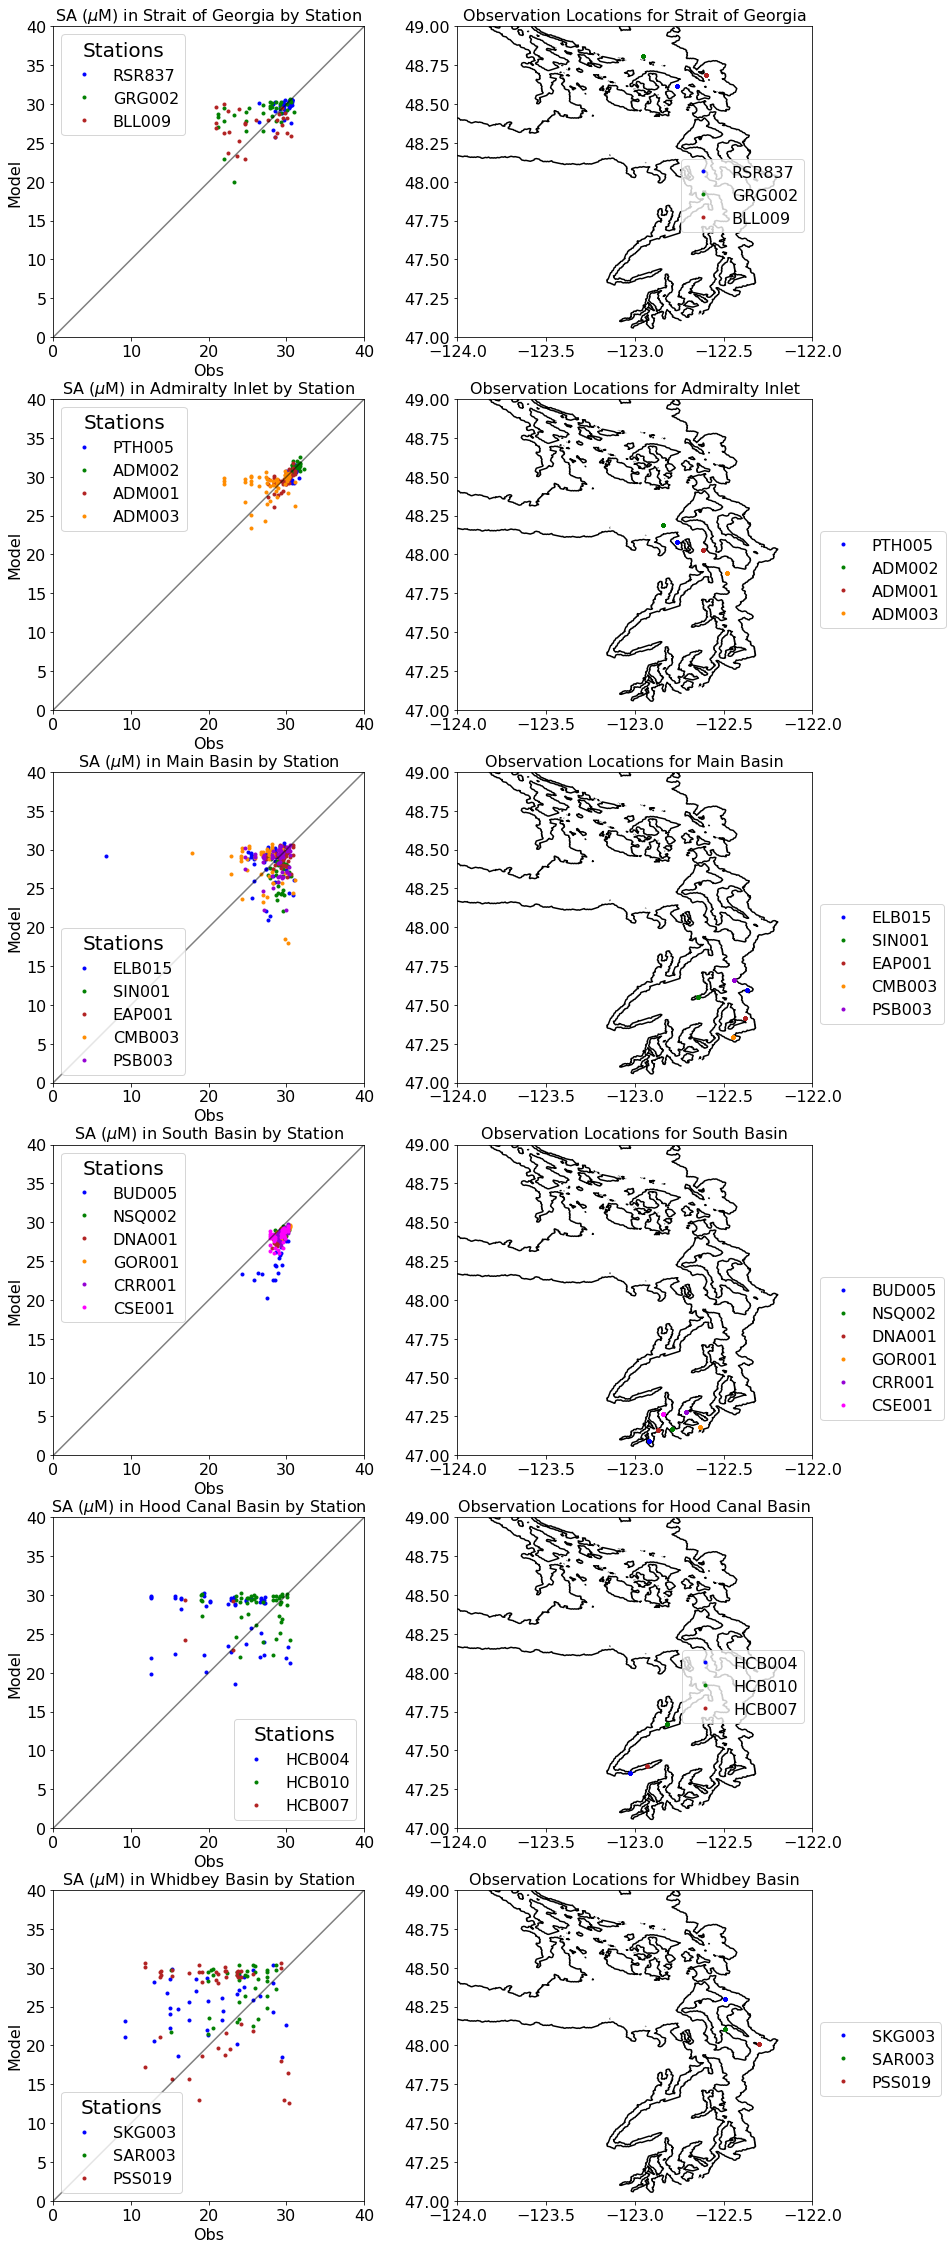

In [34]:
obsvar='SA'
modvar='mod_vosaline'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']
lims=(0,40)

ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

#This should be added into the notebook. 

Send an example to Puget Eval, that way we can talk over any other parameters or additions to the script. 